In [ ]:
using Random
using PauliPropagation
using ProgressBars
using DataFrames
using CSV
using Plots
using LaTeXStrings

In [ ]:
# Build evolution angles for TFIM model
function get_tfim_couplings(circuit, deltat::Float64; J=1, hz=0.9045, hx=1.4)
    thetas = []

    indices_gate_zz = getparameterindices(circuit, PauliRotation, [:Z, :Z])
    indices_gate_x = getparameterindices(circuit, PauliRotation, [:X])
    indices_gate_z = getparameterindices(circuit, PauliRotation, [:Z])

    for (idx, gate) in enumerate(circuit)

        if idx in indices_gate_zz
            coupling_strength = - deltat * J
        elseif idx in indices_gate_x
            coupling_strength = - deltat * hx
        elseif idx in indices_gate_z
            coupling_strength = - deltat * hz
        else
            throw(ArgumentError("Gate at index $idx is neither ZZ, X nor Z rotation"))
        end
        push!(thetas, coupling_strength * 2) # e^i t P / 2 * 2
    end
            
    return thetas
end


get_tfim_couplings (generic function with 1 method)

In [3]:
# Define time evolution function
"""
Perform Pauli propagation with symmetric merging.

Args:
    circuit: The circuit to be applied.
    p_init: The operator to be propagated.
    thetas: The angles for the Trotter steps.
    max_weight: The maximal operator weight.
    min_abs_coeff: Neglect small coefficients.


Returns:
    p_propagated: The evolved operator; correlation_matrix: ccorrelation matrix.
"""
function symmetric_pauli_propagation(
    nq::Int,
    p_init::PauliSum;
    max_weight=Inf,
    min_abs_coeff=0.,
    customtruncationfunction=nothing,
    nl=1,
    deltat=0.25,
    periodic=true,
    circuit = tiltedtfitrottercircuit,
    topology=bricklayertopology,
    gx=1.4,
    gz=0.9045,
    merging=nothing,
)
    circ = circuit(nq, 1; topology=topology(nq, periodic=periodic))
    thetas = get_tfim_couplings(circ, deltat; J=1, hz=gz, hx=gx)
    
    p_propagated = p_init

    for i in 1:nl
        # Pauli propagation for a single Trotter step
        p_propagated = propagate(
            circ, p_propagated, thetas; max_weight=max_weight, 
            min_abs_coeff=min_abs_coeff,
            customtruncationfunction=customtruncationfunction
        )
        
        # Perform symmetry merging
        if merging == :full
            # println("Full merging")
            p_propagated = translationmerge(p_propagated)
        end
    end

    return p_propagated
end

symmetric_pauli_propagation

In [ ]:

function run_pp(nx, ny, layers; merging=:none, deltat=0.25,  gx=gx, gz=gz, nl=1, periodic=periodic, 
                    max_weight=max_weight, min_abs_coeff=min_abs_coeff, noise=noise, max_nodes=max_nodes,
    savefile=false, filename="none", jobid=0, taskid=0
)

    results = Vector{NamedTuple}()
    df = DataFrame(results)

    nq = nx * ny  # Number of qubits
    println("Number of qubits: ", nq)
    
    # Initialize the Pauli operator
    p_init = PauliSum(PauliString(nq, :Z, div(nq, 2) + 1))
    propagated = p_init  # Initial operator to propagate  
    
    nl = maximum(layers)  # Number of layers

    total_compute_time = 0          
    for i in tqdm(0:nl+1)
        
        if i > 0
          # Perform the propagation
          propagated_timed = @timed symmetric_pauli_propagation(
              nq, propagated; gx=gx, gz=gz, nl=1, periodic=periodic, 
                    max_weight=max_weight, min_abs_coeff=min_abs_coeff, merging=merging,
          )             
          propagated = propagated_timed.value
        else
          propagated_timed = @timed propagated
        end

        total_compute_time += propagated_timed.time

        # check the length of the psum
        if length(propagated) > max_nodes
            println("Reading nodes $(length(propagated)) the propagation at layer ", i, " for nq = ", nq)
            break
        end
        
        if i in layers
            ev = overlapwithplus(propagated)
            
            push!(results, (
                merging = String(merging),
                nq = nq,
                nx = nx,
                ny = ny,
                layer = i,
                time = i * deltat,
                ev = ev,
                compute_time = propagated_timed.time, 
                total_compute_time = total_compute_time,
                paulinodes = length(propagated),
                alpha = alpha,
                gx = gx,
                gz = gz,
                noise = noise,
                deltat = deltat,
                periodic = periodic,                        
                max_weight = max_weight,
                min_abs_coeff = min_abs_coeff,
                max_nodes = max_nodes,
                jobid = jobid,
                taskid = taskid
            ))
            
            # Store the results
            df = DataFrame(results)   
            if savefile
                CSV.write(filename, df)
            end           
        end 

    end
    return df
 
  end
  
       

function run_symmetry_comparison(argv)
    # Get config arguments 
    jobid = argv[1]
    resultdir = argv[2]
    task_id = argv[3]
    layers = argv[4]
    deltat = argv[5]
    println("Running batch experiment with jobid: ", jobid)

    savefile = false

    Random.seed!(42) # for reproducibility
    # layers = collect(0:30)
    println("Running at task id + 1:", parse(Int, task_id) + 1)
    # Merging options
    mergings = [
        :full,    # full merging
        :none,    # no merging
    ]
    
    nxs = [3, 5, 7, 11, 20]
    ny = 1
    noises = [0.]
    min_abs_coeffs = [1e-8]

    # iterating over ny and noise suing task_id
    merging, nx, noise, min_abs_coeff = collect(Base.product(mergings, nxs, noises, min_abs_coeffs))[parse(Int, task_id) + 1]
    println("Running for merging:", merging, " nx:", nx, " noise:", noise, " min_abs_coeff:", min_abs_coeff)
    
    max_nodes = Inf
    max_weight = Inf
    periodic = true
    gx = 1.4
    gz = 0.9045

    filename = resultdir * "ev_times_$(jobid)_$(task_id)_nx=$(nx)_ny=$(ny)_mergning=$(merging)_noise=$(noise)_min_abs_coeff=$(log(10, min_abs_coeff)).csv"
    
    df = run_pp(
        nx, ny, layers; merging=merging, 
        deltat=deltat, min_abs_coeff=min_abs_coeff, noise=noise,
        max_nodes=max_nodes, max_weight=max_weight,
        savefile=savefile, filename=filename,
        jobid=parse(Int, jobid), taskid=parse(Int, task_id)
    )

    println("Job finished for merging:", merging, " nx:", nx, " noise:", noise, " min_abs_coeff:", min_abs_coeff)

    return df

end

run_symmetry_comparison (generic function with 1 method)

In [10]:
nx = 5  # number of qubits
ny = 1
nq = nx * ny  # total number of qubits
nl = 80  # number of layers l
gx = 1.4  # transverse field strength
gz = 0.9045  # longitudinal field strength
deltat = 0.25  # Trotterization time step
periodic = true
truncations = [Inf]  # truncation Pauli weights
topo = bricklayertopology(nq, periodic=periodic)
p_init = PauliSum(nq)
add!(p_init, :Z, 5)

p_propagated_truncations = Dict()
for max_weight in truncations
    p_propagated = symmetric_pauli_propagation(
        nx * ny, p_init; gx=gx, gz=gz, nl=nl, periodic=periodic, 
        max_weight=max_weight, merging=:full
    )

    p_propagated_truncations[max_weight] = p_propagated
end


In [11]:
jobid = "0"
resultdir = "none"
task_id = "0"
layers = collect(0:8)
deltat = 0.25

dfs = []
for task_id in ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"]
    df = run_symmetry_comparison([jobid, resultdir, task_id, layers, deltat])
    push!(dfs, df)
end

Running batch experiment with jobid: 0
Running at task id + 1:1
Running for merging:full nx:3 noise:0.0 min_abs_coeff:1.0e-8
Number of qubits: 3


0.0%┣                                               ┫ 0/10 [00:01<00:-9, -1s/it]
10.0%┣████▏                                     ┫ 1/10 [00:01<Inf:Inf, InfGs/it]


Job finished. Results saved to: noneev_times_0_0_nx=3_ny=1_mergning=full_noise=0.0_min_abs_coeff=-8.0.csv
Running batch experiment with jobid: 0
Running at task id + 1:2
Running for merging:none nx:3 noise:0.0 min_abs_coeff:1.0e-8
Number of qubits: 3
Job finished. Results saved to: noneev_times_0_1_nx=3_ny=1_mergning=none_noise=0.0_min_abs_coeff=-8.0.csv
Running batch experiment with jobid: 0
Running at task id + 1:3
Running for merging:full nx:5 noise:0.0 min_abs_coeff:1.0e-8
Number of qubits: 5
Job finished. Results saved to: noneev_times_0_2_nx=5_ny=1_mergning=full_noise=0.0_min_abs_coeff=-8.0.csv
Running batch experiment with jobid: 0
Running at task id + 1:4
Running for merging:none nx:5 noise:0.0 min_abs_coeff:1.0e-8
Number of qubits: 5
Job finished. Results saved to: noneev_times_0_3_nx=5_ny=1_mergning=none_noise=0.0_min_abs_coeff=-8.0.csv
Running batch experiment with jobid: 0
Running at task id + 1:5
Running for merging:full nx:7 noise:0.0 min_abs_coeff:1.0e-8
Number of qubits

20.0%┣█████████▍                                     ┫ 2/10 [00:01<00:11, 1s/it]
100.0%┣█████████████████████████████████████████████┫ 10/10 [00:01<00:00, 6it/s]
100.0%┣█████████████████████████████████████████████┫ 10/10 [00:01<00:00, 6it/s]
0.0%┣                                               ┫ 0/10 [00:00<00:00, -0s/it]
100.0%┣██████████████████████████████████████████┫ 10/10 [00:00<00:00, 6.3kit/s]
100.0%┣██████████████████████████████████████████┫ 10/10 [00:00<00:00, 5.6kit/s]
0.0%┣                                               ┫ 0/10 [00:00<00:00, -0s/it]
100.0%┣███████████████████████████████████████████┫ 10/10 [00:00<00:00, 594it/s]
100.0%┣███████████████████████████████████████████┫ 10/10 [00:00<00:00, 587it/s]
0.0%┣                                               ┫ 0/10 [00:00<00:00, -0s/it]
100.0%┣██████████████████████████████████████████┫ 10/10 [00:00<00:00, 2.5kit/s]
100.0%┣██████████████████████████████████████████┫ 10/10 [00:00<00:00, 2.4kit/s]
0.0%┣                       

Job finished. Results saved to: noneev_times_0_5_nx=7_ny=1_mergning=none_noise=0.0_min_abs_coeff=-8.0.csv
Running batch experiment with jobid: 0
Running at task id + 1:7
Running for merging:full nx:11 noise:0.0 min_abs_coeff:1.0e-8
Number of qubits: 11


100.0%┣███████████████████████████████████████████┫ 10/10 [00:00<00:00, 185it/s]
100.0%┣███████████████████████████████████████████┫ 10/10 [00:00<00:00, 184it/s]
0.0%┣                                               ┫ 0/10 [00:00<00:00, -0s/it]
20.0%┣█████████▍                                     ┫ 2/10 [00:00<00:01, 6it/s]
60.0%┣███████████████████████████▋                  ┫ 6/10 [00:00<00:00, 15it/s]
70.0%┣█████████████████████████████████              ┫ 7/10 [00:01<00:01, 5it/s]
80.0%┣█████████████████████████████████████▋         ┫ 8/10 [00:02<00:01, 3it/s]
90.0%┣██████████████████████████████████████████▎    ┫ 9/10 [00:04<00:00, 2it/s]


Job finished. Results saved to: noneev_times_0_6_nx=11_ny=1_mergning=full_noise=0.0_min_abs_coeff=-8.0.csv
Running batch experiment with jobid: 0
Running at task id + 1:8
Running for merging:none nx:11 noise:0.0 min_abs_coeff:1.0e-8
Number of qubits: 11


100.0%┣█████████████████████████████████████████████┫ 10/10 [00:05<00:00, 2it/s]
100.0%┣█████████████████████████████████████████████┫ 10/10 [00:05<00:00, 2it/s]
0.0%┣                                               ┫ 0/10 [00:00<00:00, -0s/it]
20.0%┣█████████▍                                     ┫ 2/10 [00:00<00:01, 8it/s]
60.0%┣███████████████████████████▋                  ┫ 6/10 [00:00<00:00, 17it/s]
70.0%┣█████████████████████████████████              ┫ 7/10 [00:02<00:01, 4it/s]
80.0%┣█████████████████████████████████████▋         ┫ 8/10 [00:05<00:02, 1it/s]
90.0%┣██████████████████████████████████████████▎    ┫ 9/10 [00:10<00:01, 1s/it]


Job finished. Results saved to: noneev_times_0_7_nx=11_ny=1_mergning=none_noise=0.0_min_abs_coeff=-8.0.csv
Running batch experiment with jobid: 0
Running at task id + 1:9
Running for merging:full nx:20 noise:0.0 min_abs_coeff:1.0e-8
Number of qubits: 20


100.0%┣█████████████████████████████████████████████┫ 10/10 [00:14<00:00, 2s/it]
100.0%┣█████████████████████████████████████████████┫ 10/10 [00:14<00:00, 2s/it]
0.0%┣                                               ┫ 0/10 [00:00<00:00, -0s/it]
20.0%┣█████████▍                                     ┫ 2/10 [00:00<00:01, 6it/s]
60.0%┣███████████████████████████▋                  ┫ 6/10 [00:00<00:00, 11it/s]
70.0%┣█████████████████████████████████              ┫ 7/10 [00:02<00:01, 4it/s]
80.0%┣█████████████████████████████████████▋         ┫ 8/10 [00:08<00:02, 1s/it]
90.0%┣██████████████████████████████████████████▎    ┫ 9/10 [00:39<00:05, 5s/it]


Job finished. Results saved to: noneev_times_0_8_nx=20_ny=1_mergning=full_noise=0.0_min_abs_coeff=-8.0.csv
Running batch experiment with jobid: 0
Running at task id + 1:10
Running for merging:none nx:20 noise:0.0 min_abs_coeff:1.0e-8
Number of qubits: 20


100.0%┣████████████████████████████████████████████┫ 10/10 [03:47<00:00, 25s/it]
100.0%┣████████████████████████████████████████████┫ 10/10 [03:47<00:00, 25s/it]
0.0%┣                                               ┫ 0/10 [00:00<00:00, -0s/it]
20.0%┣█████████▍                                     ┫ 2/10 [00:00<00:01, 8it/s]
60.0%┣███████████████████████████▋                  ┫ 6/10 [00:00<00:00, 14it/s]
70.0%┣█████████████████████████████████              ┫ 7/10 [00:02<00:01, 2it/s]
80.0%┣█████████████████████████████████████▋         ┫ 8/10 [00:14<00:04, 2s/it]
90.0%┣█████████████████████████████████████████▍    ┫ 9/10 [01:21<00:10, 10s/it]


Job finished. Results saved to: noneev_times_0_9_nx=20_ny=1_mergning=none_noise=0.0_min_abs_coeff=-8.0.csv


100.0%┣████████████████████████████████████████████┫ 10/10 [10:15<00:00, 68s/it]
100.0%┣████████████████████████████████████████████┫ 10/10 [10:15<00:00, 68s/it]


In [12]:
final_df = vcat(dfs...)

Row,merging,nq,nx,ny,layer,time,ev,compute_time,total_compute_time,paulinodes,alpha,gx,gz,noise,deltat,periodic,max_weight,min_abs_coeff,max_nodes,jobid,taskid
,String,Int64,Int64,Int64,Int64,Float64,Float64,Float64,Float64,Int64,#alpha…,Float64,Float64,Float64,Float64,Bool,Float64,Float64,Float64,Int64,Int64
1,full,3,3,1,0,0.0,0.0,0.0,0.0,1,alpha,1.4,0.9045,0.0,0.25,true,Inf,1.0e-8,Inf,0,0
2,full,3,3,1,1,0.25,0.216811,0.153463,0.153463,9,alpha,1.4,0.9045,0.0,0.25,true,Inf,1.0e-8,Inf,0,0
3,full,3,3,1,2,0.5,0.334094,3.8125e-5,0.153501,23,alpha,1.4,0.9045,0.0,0.25,true,Inf,1.0e-8,Inf,0,0
4,full,3,3,1,3,0.75,0.195515,1.725e-5,0.153518,23,alpha,1.4,0.9045,0.0,0.25,true,Inf,1.0e-8,Inf,0,0
5,full,3,3,1,4,1.0,-0.0204018,1.1375e-5,0.15353,23,alpha,1.4,0.9045,0.0,0.25,true,Inf,1.0e-8,Inf,0,0
6,full,3,3,1,5,1.25,-0.195477,9.375e-6,0.153539,23,alpha,1.4,0.9045,0.0,0.25,true,Inf,1.0e-8,Inf,0,0
7,full,3,3,1,6,1.5,-0.180434,8.75e-6,0.153548,23,alpha,1.4,0.9045,0.0,0.25,true,Inf,1.0e-8,Inf,0,0
8,full,3,3,1,7,1.75,0.0923388,8.459e-6,0.153556,23,alpha,1.4,0.9045,0.0,0.25,true,Inf,1.0e-8,Inf,0,0
9,full,3,3,1,8,2.0,0.480341,9.375e-6,0.153566,23,alpha,1.4,0.9045,0.0,0.25,true,Inf,1.0e-8,Inf,0,0


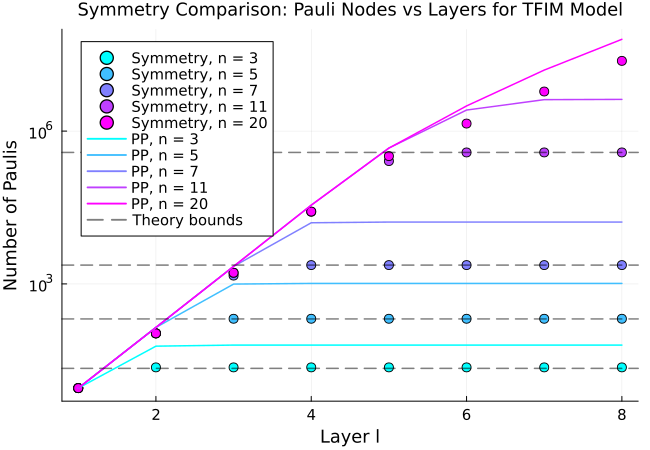

In [55]:
#plot results

# --- custom style setup (plt.rcParams.update) ---
# You can use `default()` to set style options globally
default(
    linewidth = 1.5,
    markersize = 5,
    legendfontsize = 10,
    guidefontsize = 12,
    tickfontsize = 10,
    titlefontsize = 12,
    color_palette = :cool,
)

# --- Create the figure and axis ---
fig = plot(size = (650, 450))  # figsize=(6, 4.5) inches roughly → (600, 450) pixels

# --- Filter dataframe ---
df_largenq = filter(row -> row.layer > 0, final_df)

# --- Colorbar, hue, style ---
# Suppose df has columns: :layer, :paulinodes, :nq, :merging
# We'll group by :merging for style, and color by :nq

subdf = filter(row -> row.merging == "full", df_largenq)
ncolors = length(unique(subdf.nq))
gradient = cgrad(:cool)
cols = [gradient[i / (ncolors - 1)] for i in 0:(ncolors - 1)]
for (i, nq) in enumerate(sort(unique(subdf.nq)))
    groupdf = filter(row -> row.nq == nq, subdf)
    scatter!(
        groupdf.layer,
        groupdf.paulinodes,
        color = cols[i],
        label = "Symmetry, n = $nq",
        yscale = :log10,
    )
end

subdf = filter(row -> row.merging == "none", df_largenq)
ncolors = length(unique(subdf.nq))
gradient = cgrad(:cool)
cols = [gradient[i / (ncolors - 1)] for i in 0:(ncolors - 1)]
for (i, nq) in enumerate(sort(unique(subdf.nq)))
    groupdf = filter(row -> row.nq == nq, subdf)
    plot!(
        groupdf.layer,
        groupdf.paulinodes,
        color = cols[i],
        label = "PP, n = $nq",
        yscale = :log10,
    )
end

# --- Plot theory bounds ---
qubits = sort(unique(df_largenq.nq))
layers = sort(unique(df_largenq.layer))
theory_bounds = [(4^n + n - 1) / n for n in qubits]

for (i, n) in enumerate(qubits)
    hline!(
        [theory_bounds[i]],
        color = :black,
        linestyle = :dash,
        label = i == 1 ? "Theory bounds" : "",
        alpha = 0.5,
    )
end

# --- Axis labels and limits ---
xlabel!("Layer l")
ylabel!("Number of Paulis")
ylims!(5, 1e8)

# --- Legend placement ---
plot!(legend = :topleft)

title!("Symmetry Comparison: Pauli Nodes vs Layers for TFIM Model")

# --- Save the figure ---
# savefig("/Users/yanting/Repositories/SymMerging/Figures/fig2_tfim.pdf")

display(fig)
